# <p><center style="font-family:newtimeroman;font-size:180%;">Image Colorization Using Auto Encoder </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Train Auto Encoder Model](#5)
* [Evaluate The Model](#6)

**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [2]:
# Load CIFAR-10 dataset
(X_train, _), (X_test, _) = keras.datasets.cifar10.load_data()
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
X_train shape is  (50000, 32, 32, 3)
X_test shape is  (10000, 32, 32, 3)


In [3]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [4]:
X_train_gray = np.dot(X_train[..., :3], [0.2989, 0.5870, 0.1140])
X_test_gray = np.dot(X_test[..., :3], [0.2989, 0.5870, 0.1140])
print('X_train_gray shape is ' , X_train_gray.shape)
print('X_test_gray shape is ' , X_test_gray.shape)

X_train_gray shape is  (50000, 32, 32)
X_test_gray shape is  (10000, 32, 32)


In [5]:
X_train_gray = np.expand_dims(X_train_gray, axis=-1)
X_test_gray = np.expand_dims(X_test_gray, axis=-1)
print('X_train_gray shape is ' , X_train_gray.shape)
print('X_test_gray shape is ' , X_test_gray.shape)

X_train_gray shape is  (50000, 32, 32, 1)
X_test_gray shape is  (10000, 32, 32, 1)


**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

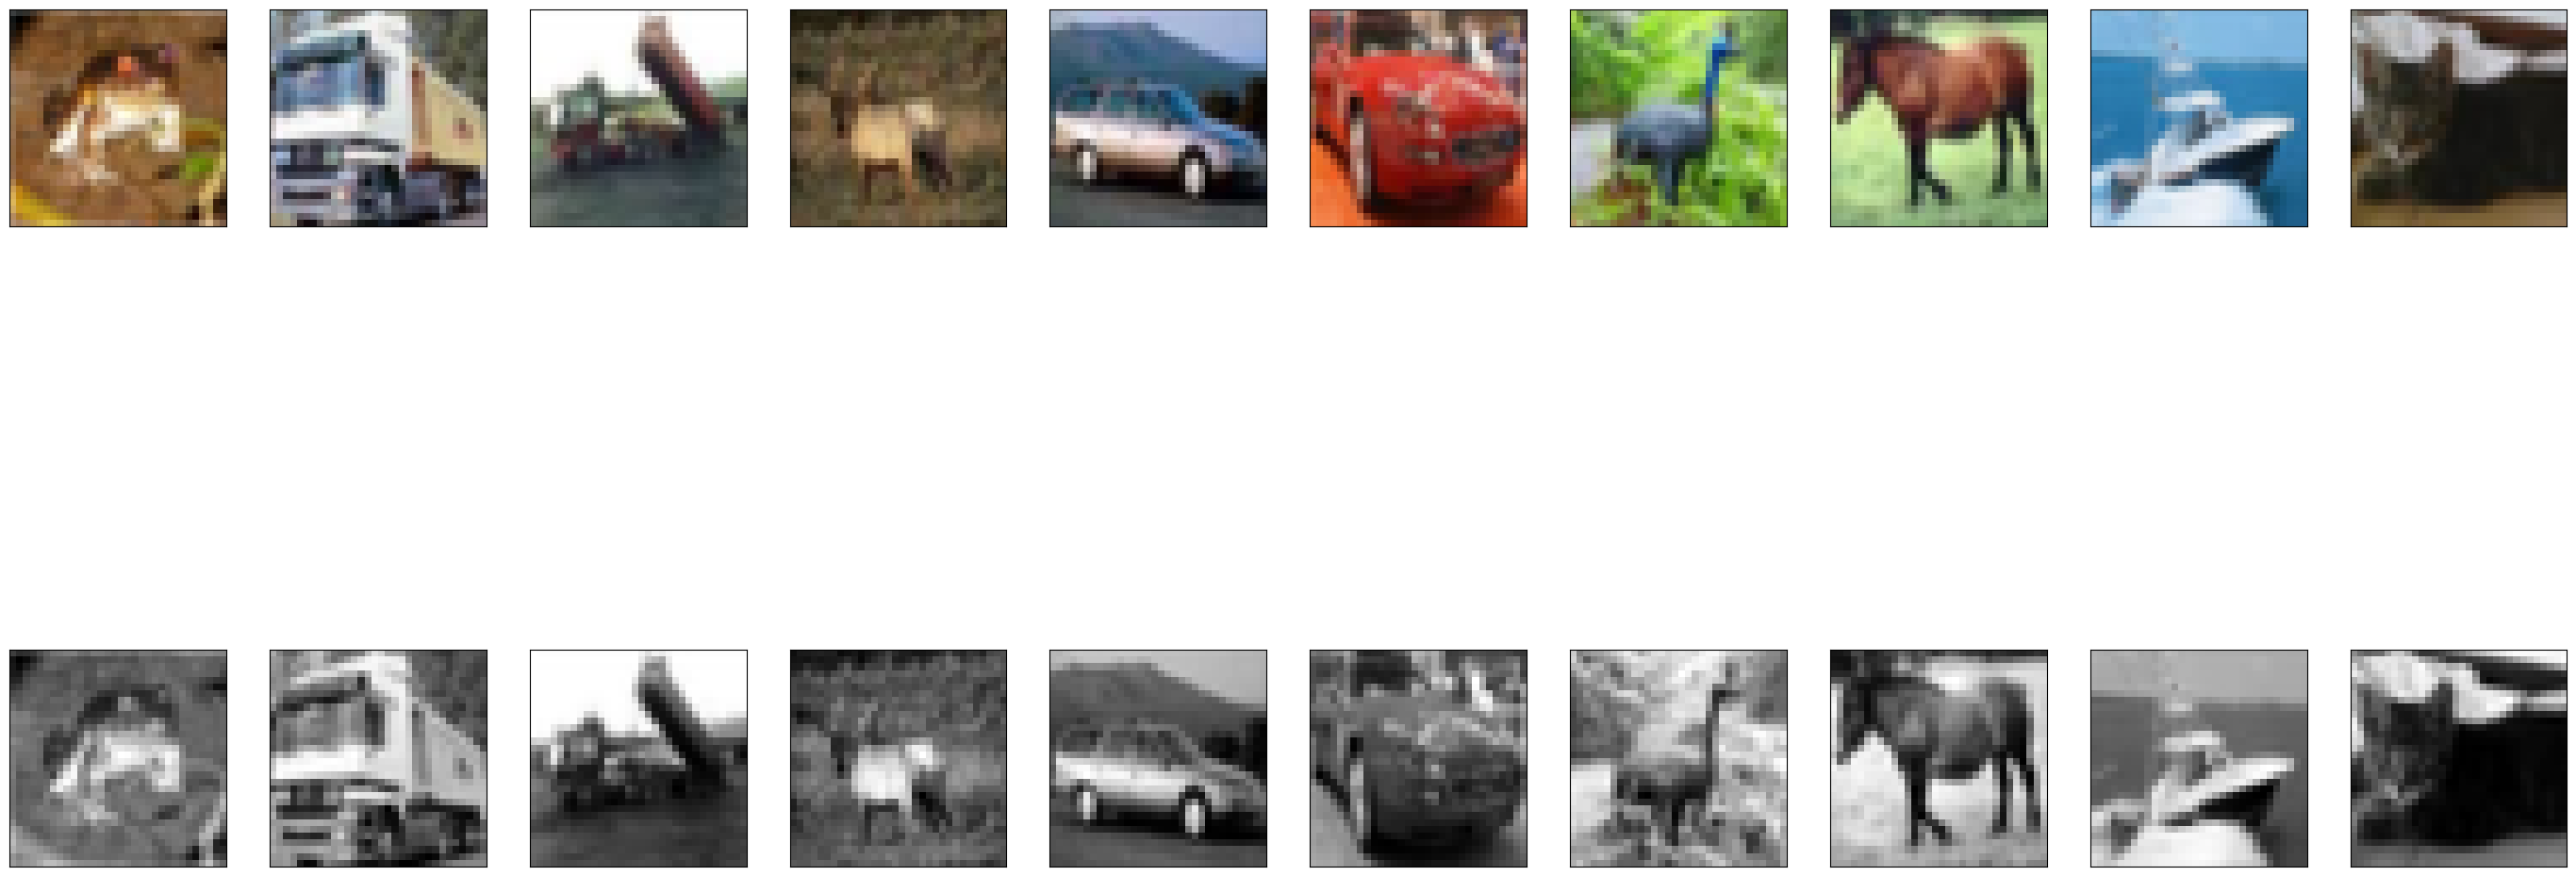

In [6]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_train_gray[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

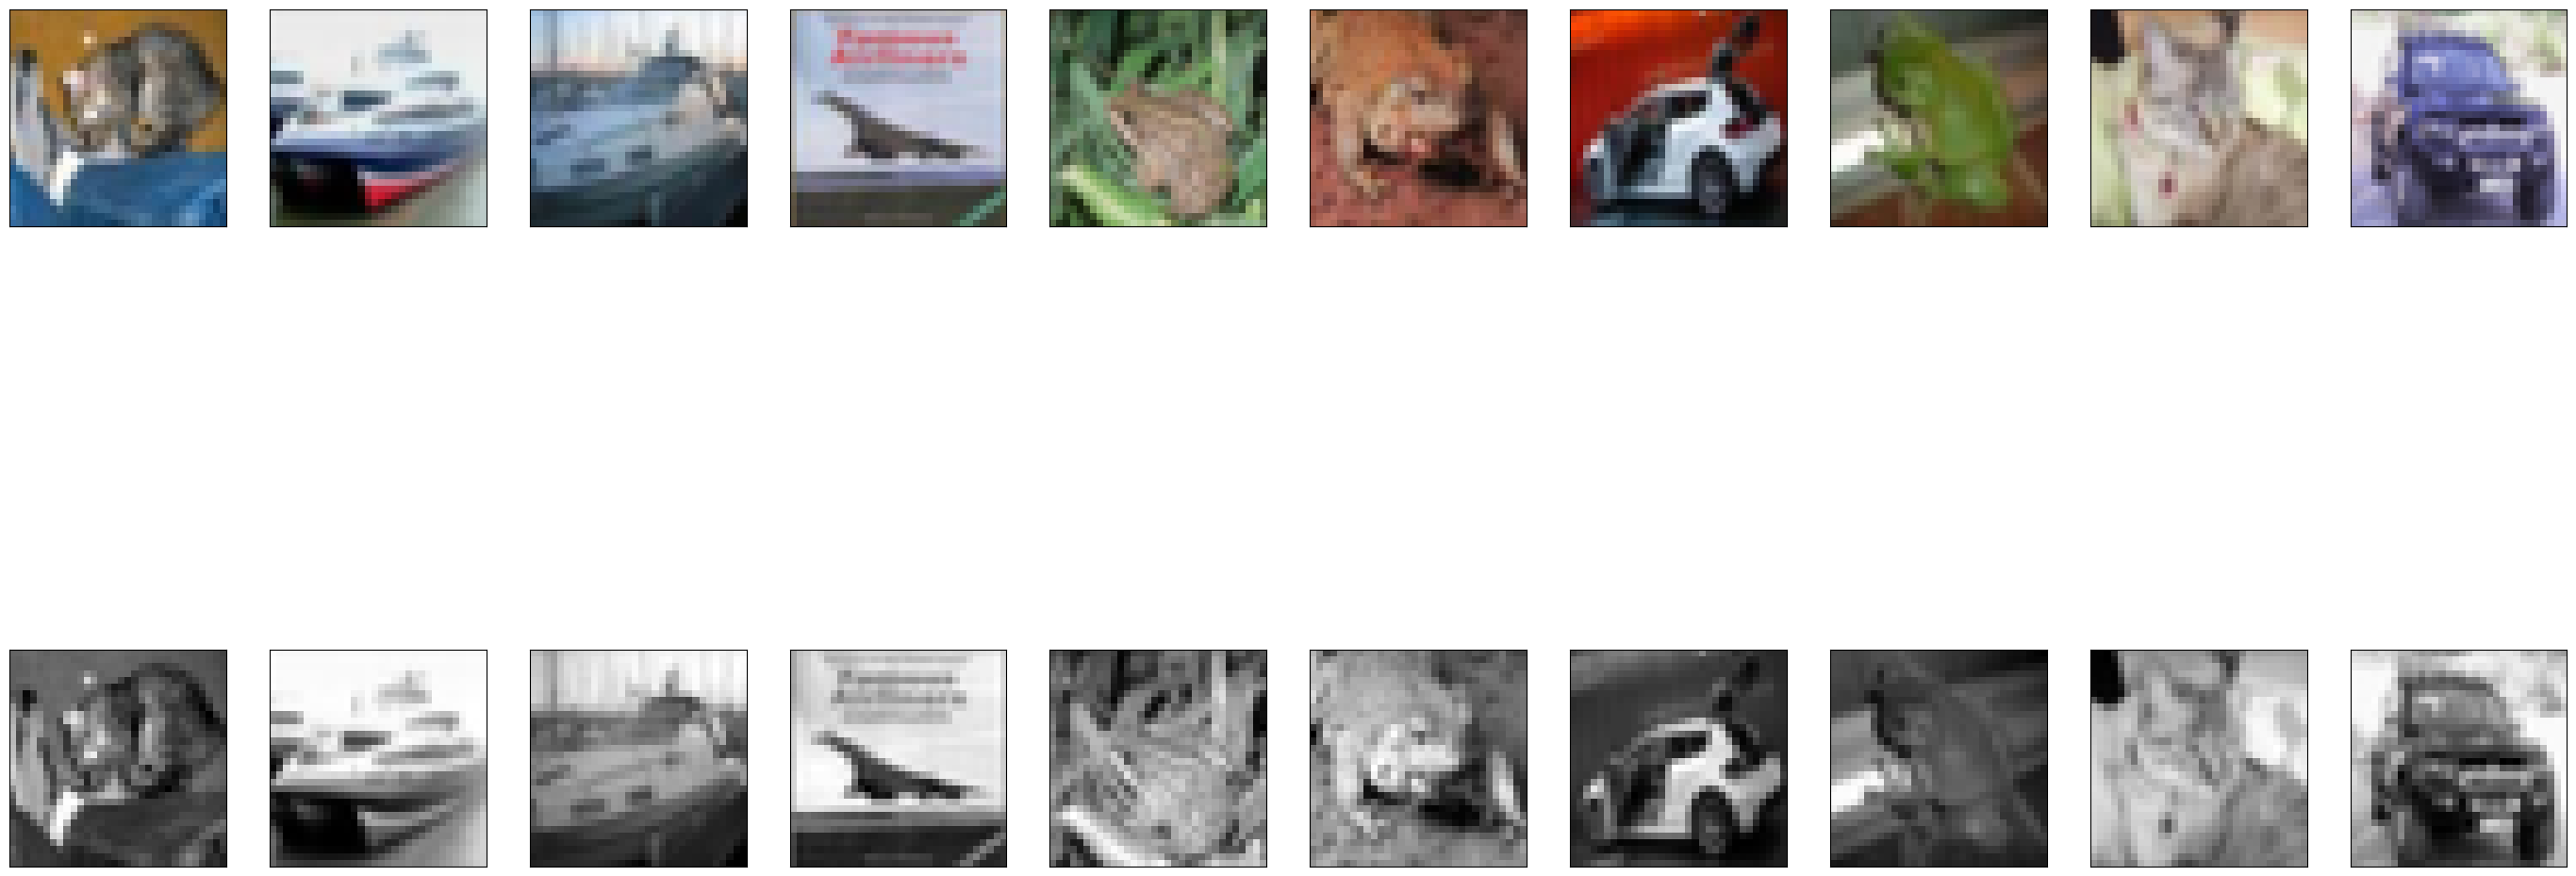

In [7]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_test_gray[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

<a id="5"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [8]:
# Input layer with shape (200, 200, 1)
input_ = keras.layers.Input(shape=(32,32, 1))
# Encoder
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
encoder = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
# Decoder
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
# Adjust the output layer for an RGB image (3 channels)
decoder = keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
# Autoencoder model
autoencoder = keras.models.Model(inputs=input_, outputs=decoder)
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928 

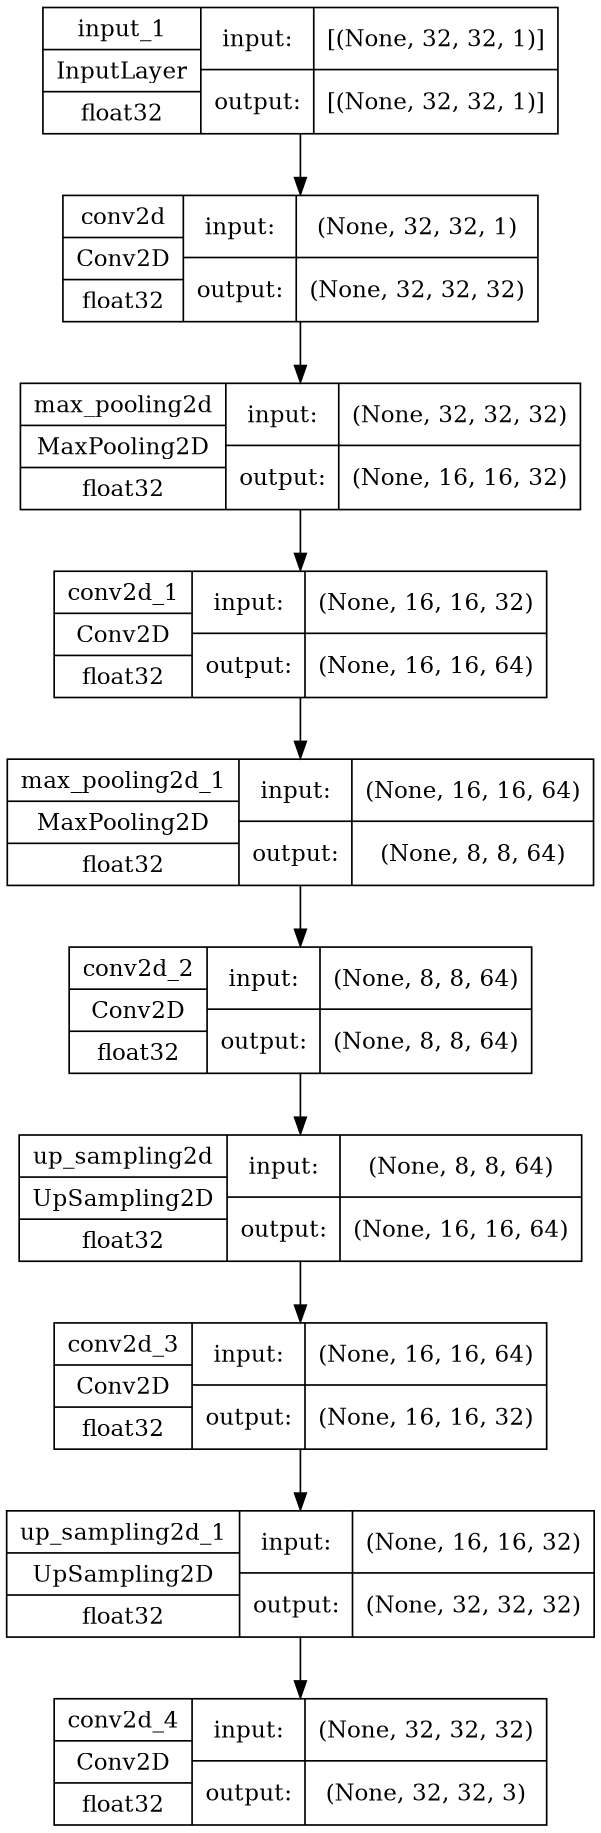

In [9]:
tf.keras.utils.plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [10]:
checkpoint_cb =ModelCheckpoint("autoencoder.h5",save_best_only=True)
autoencoder.compile(optimizer ='adam', loss='mse')
hist=autoencoder.fit(X_train_gray,X_train,epochs=200,validation_data=(X_test_gray,X_test),callbacks=[checkpoint_cb])

Epoch 1/200
1563/1563 [==============================] - 23s 5ms/step - loss: 0.0113 - val_loss: 0.0090
Epoch 2/200
  26/1563 [..............................] - ETA: 6s - loss: 0.0092

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - 7s 5ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 3/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 4/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 5/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 6/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 7/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 8/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 10/200
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 11/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0066

<a id="6"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [11]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,val_loss
0,0.011326,0.008974
1,0.008682,0.008242
2,0.007962,0.007572
3,0.007520,0.007154
4,0.007237,0.007052
...,...,...
195,0.005850,0.006024
196,0.005836,0.005959
197,0.005860,0.005860
198,0.005857,0.005926


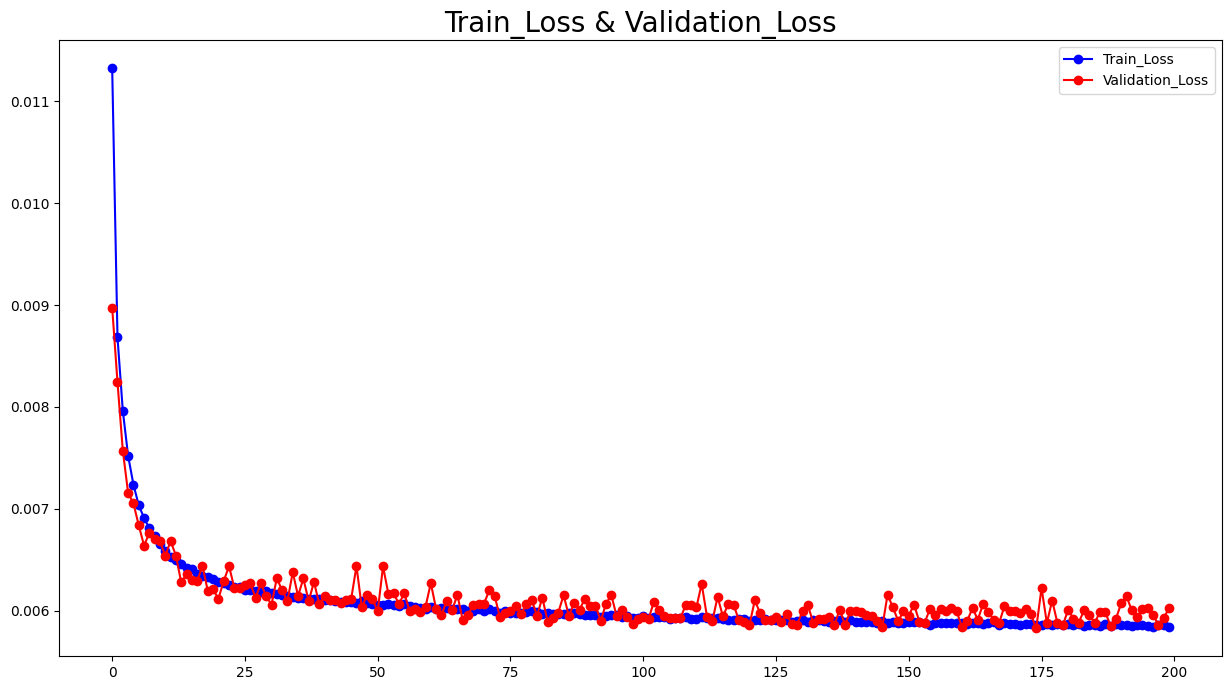

In [12]:
plt.figure(figsize=(15,8))
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.show()

In [13]:
autoencoder.evaluate(X_test_gray,X_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0060


0.006022216286510229

In [14]:
predictions = autoencoder.predict(X_test_gray)
predictions.shape

313/313 [==============================] - 1s 2ms/step


(10000, 32, 32, 3)

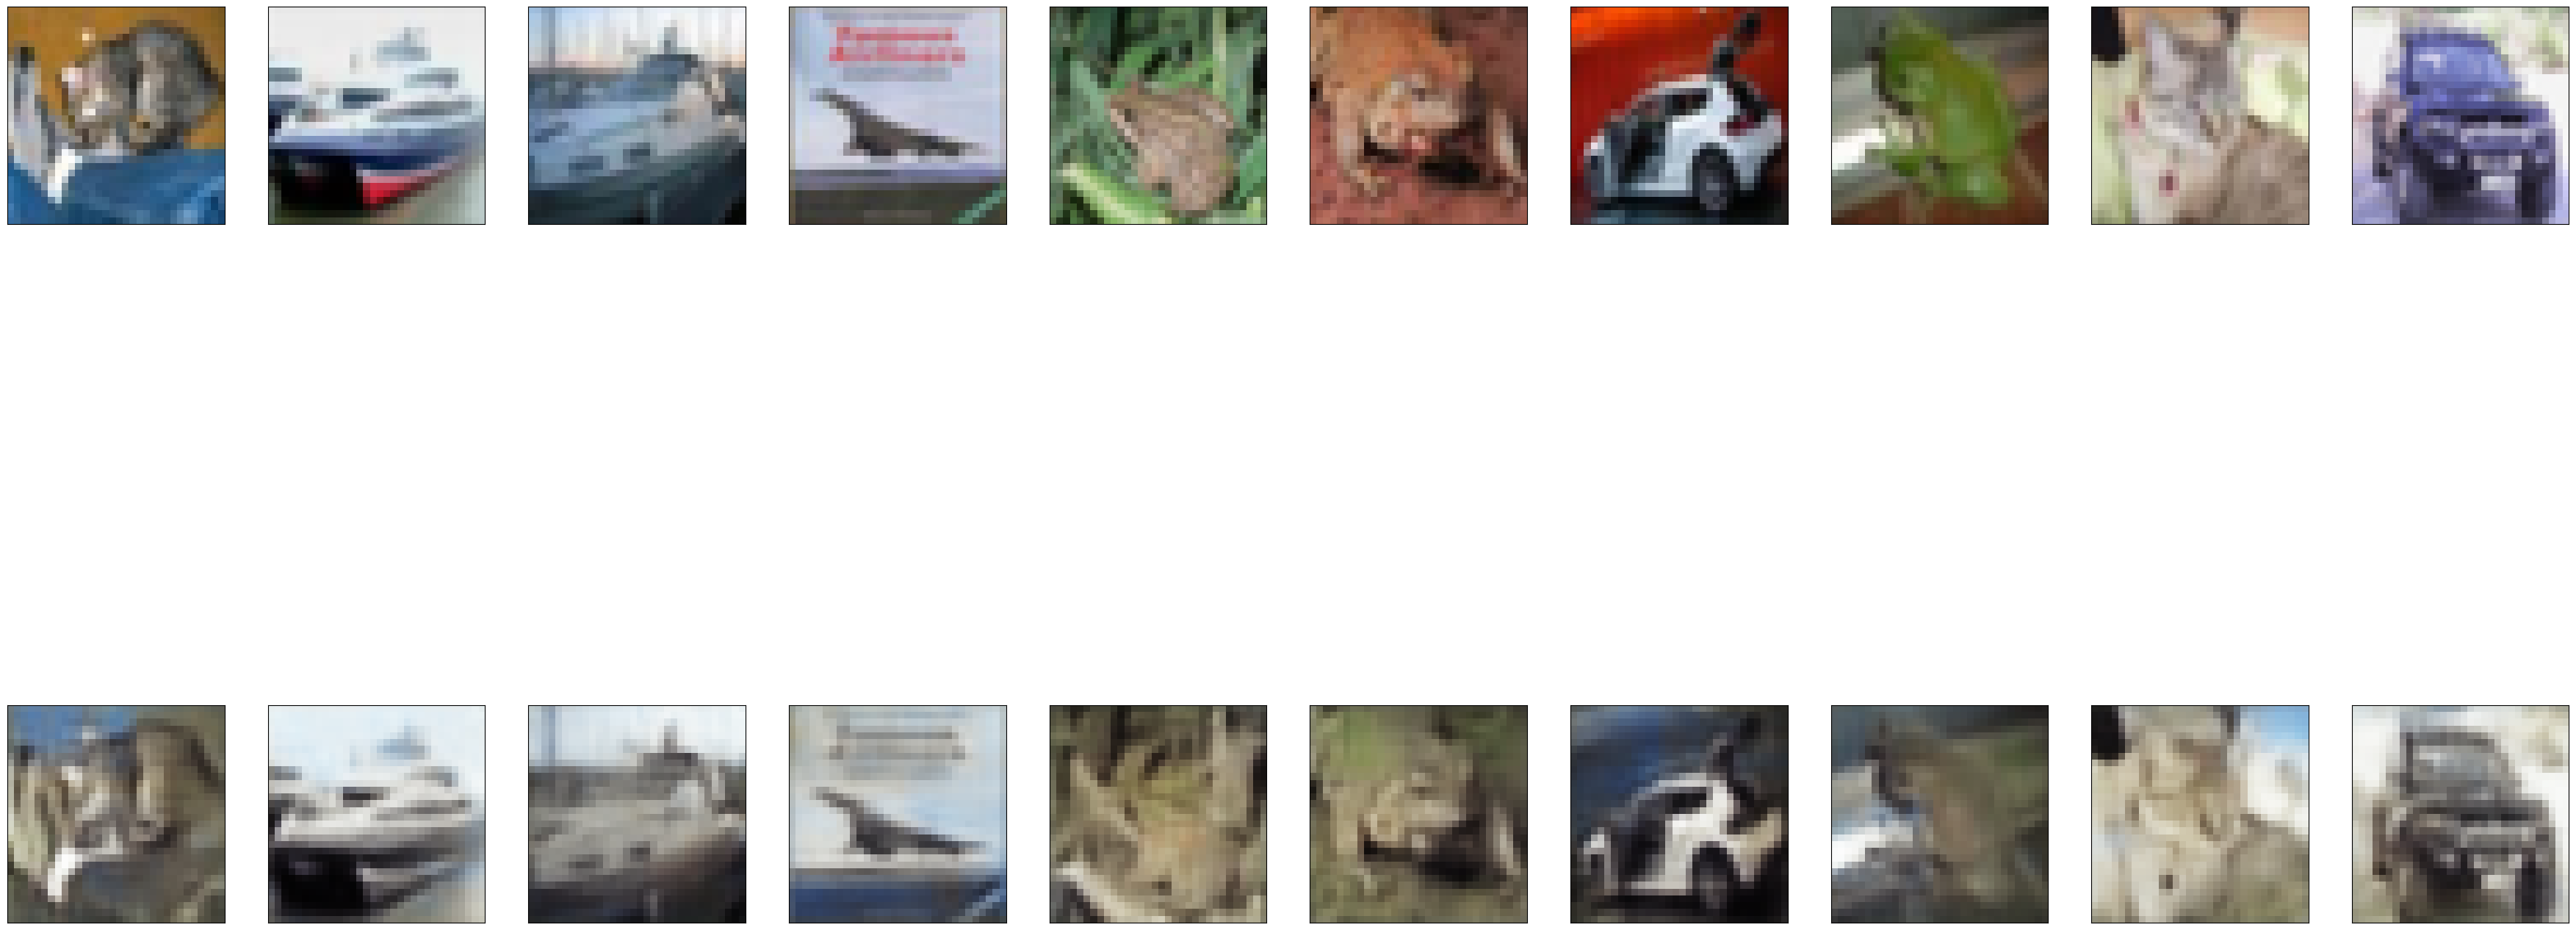

In [15]:
n=10
plt.figure(figsize=(45,35))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predictions[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [16]:
psnr_values=[abs(peak_signal_noise_ratio(color,pred,data_range=color.max()-pred.min())) 
             for color,pred in zip(X_test,predictions)]
print('Average PSNR =',np.mean(psnr_values))

Average PSNR = 22.211953175117955
